# Bayesian Network

This notebook demonstrates the process of training Bayesian Networks (BNs) for sentiment classification using the Twitter and Reddit Dataset (adapted for probabilistic graphical modeling). The main steps include:

- Preprocessing and vectorizing sentences using sentence embeddings and k-means clustering
- Discretizing features to construct a categorical dataset
- Learning the network structure using Hill Climbing with the BIC scoring function
- Estimating conditional probability distributions (CPDs) from the training data
- Predicting sentiment of unseen sentences via probabilistic inference
- Evaluating classification performance with standard metrics such as accuracy, precision, and recall

Our goal is to capture dependencies among latent textual features and the sentiment label, and to explore how structured probabilistic reasoning can be applied to sentiment classification.


In [ ]:
# General libraries
import pandas as pd
import os
import numpy as np

# Libraries for processing the data
import re

# Library for processing text
from sentence_transformers import SentenceTransformer

# Libraries for model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator, BIC
from pgmpy.inference import VariableElimination

# Library for drawing
import matplotlib.pyplot as plt

### 1. Prepare Data

In this section, we prepare the data by:
- Grouping the dataset from Twitter and Reddit
- Splitting this big dataset into training and testing sets

In [2]:
# Read raw data and drop the missing values
# df_twitter = pd.read_csv('../../data/raw/dataset_phase_2/Twitter_Data.csv')
df_twitter = pd.read_csv('/content/Twitter_Data.csv')
df_twitter = df_twitter.loc[:, ~df_twitter.columns.str.contains('Unnamed: 0')]
df_twitter = df_twitter.rename(columns={"clean_text": "text"})
df_twitter.dropna(subset=["text", "category"], inplace=True)

# df_reddit = pd.read_csv('../../data/raw/dataset_phase_2/Reddit_Data.csv')
df_reddit = pd.read_csv('/content/Reddit_Data.csv')
df_reddit = df_reddit.loc[:, ~df_reddit.columns.str.contains('Unnamed: 0')]
df_reddit = df_reddit.rename(columns={"clean_comment": "text"})
df_reddit.dropna(subset=["text", "category"], inplace=True)

# Combine into a dataset for both sources
df = pd.concat([df_twitter, df_reddit], ignore_index=True)
df

,text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
200113,jesus,0.0
200114,kya bhai pure saal chutiya banaya modi aur jab...,1.0
200115,downvote karna tha par upvote hogaya,0.0
200116,haha nice,1.0


In [3]:
# Split the dataset into training set and test set
def split_dataset(df):
    return train_test_split(
        df,
        test_size = 0.2,
        stratify = df["category"],
        random_state = 42
    )

df_train, df_test = split_dataset(df)
df_train, df_test

(                                                     text  category
 57976   making fun achievements country politics lies ...       1.0
 132223  modi spends crores facials ignores the faceles...       0.0
 41826   wants grow your business india start contact 9...       1.0
 18622   choice this pic best the reaction modi hearing...       1.0
 161135  bjp will better than 2014 along with other par...       1.0
 ...                                                   ...       ...
 175604  they are hellbent the left good right bad narr...       1.0
 58355   fantastic leadership modi jai maa bharti\nindi...       1.0
 145456  sir this info good for academic interest but d...       1.0
 93922   can recollect those sweet memory 2014 campaign...       1.0
 744         modi has merely renamed out congress schemes       -1.0
 
 [160094 rows x 2 columns],
                                                      text  category
 51562   congratulate rahul gandhi for helping modi bec...       1.0
 161

### 2. Build Features

In this step, we preprocess the text data and transform it into a format suitable for Bayesian Network learning by performing the following:
- **Sentence Embedding**: Each sentence is converted into a fixed-size vector using pre-trained sentence transformers to capture semantic meaning.
- **Clustering**: The embedding space is partitioned using k-means clustering, grouping semantically similar sentences into discrete clusters.
- **Discretization**: Cluster IDs are used to form categorical node values for the Bayesian Network, transforming continuous embeddings into symbolic representations.
- **Label Alignment**: Each discretized record is associated with its original sentiment label (Positive, Negative, or Neutral) to enable supervised structure and parameter learning.

This transformation ensures that the input data is fully categorical and structured, making it compatible with the requirements of Bayesian Network training and inference.

In [4]:
# Clean the text - Remove punctuation
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text

In [5]:
def encode_train_data(df_train):
  # Load a pre-trained sentence embedding model
  process_model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight and fast

  cleaned_sentences = df_train['text'].apply(clean_text).tolist()

  return process_model.encode(cleaned_sentences, convert_to_numpy=True)

sentence_embeddings = encode_train_data(df_train)
sentence_embeddings

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


array([[ 0.01952787,  0.07614514, -0.00039013, ..., -0.01560431,
         0.01652394, -0.01090715],
       [ 0.01651943,  0.0892062 ,  0.0219552 , ..., -0.06352679,
        -0.03786116,  0.00415434],
       [-0.08064984, -0.05409399, -0.04284878, ..., -0.0282996 ,
        -0.02892304,  0.0037986 ],
       ...,
       [-0.03090181, -0.02931664, -0.03846788, ..., -0.05335171,
        -0.03549575, -0.03797226],
       [-0.09753831,  0.02071587, -0.01392264, ..., -0.04901715,
        -0.1260641 ,  0.00246387],
       [-0.04450557,  0.01968879,  0.01122654, ..., -0.04014087,
         0.0325805 , -0.04955564]], dtype=float32)

In [17]:
def cluster_sentences(embeddings, k_clusters=5, n_chunks=6):
  embedding_dim = embeddings.shape[1]  # should be 384
  chunk_size = embedding_dim // n_chunks

  # For each chunk, fit KMeans and discretize
  discrete_features = []

  for i in range(n_chunks):
      chunk = embeddings[:, i*chunk_size : (i+1)*chunk_size]
      kmeans = KMeans(n_clusters=k_clusters, random_state=42)
      cluster_ids = kmeans.fit_predict(chunk)
      discrete_features.append(cluster_ids)

  # Transpose and stack to shape (n_samples, n_chunks)
  return np.array(discrete_features).T

discrete_features = cluster_sentences(sentence_embeddings)
discrete_features

array([[4, 1, 0, 1, 0, 0],
       [4, 3, 2, 1, 1, 0],
       [0, 4, 3, 2, 2, 2],
       ...,
       [2, 4, 3, 0, 0, 0],
       [0, 0, 1, 1, 4, 4],
       [2, 3, 1, 4, 1, 3]], dtype=int32)

In [18]:
def create_df_discrete(df_train, n_chunks=6):
  # Create columns: Node_1, Node_2, ..., Node_n
  node_columns = [f'Node_{i+1}' for i in range(n_chunks)]
  df_discrete = pd.DataFrame(discrete_features, columns=node_columns)

  # Add the label column
  df_discrete['Label'] = df_train['category'].values

  return df_discrete

df_discrete = create_df_discrete(df_train)
df_discrete

,Node_1,Node_2,Node_3,Node_4,Node_5,Node_6,Label
0,4,1,0,1,0,0,1.0
1,4,3,2,1,1,0,0.0
2,0,4,3,2,2,2,1.0
3,3,0,1,1,1,3,1.0
4,0,3,0,0,0,0,1.0
...,...,...,...,...,...,...,...
160089,4,1,0,2,2,0,1.0
160090,3,4,1,4,0,0,1.0
160091,2,4,3,0,0,0,1.0
160092,0,0,1,1,4,4,1.0


### 3. Model training

In this section, we train a Bayesian Network (BN) for sentiment classification using the preprocessed and discretized features derived from the sentence embeddings.

The steps involved are:
- **Structure Learning**: We use the Hill Climbing algorithm with the Bayesian Information Criterion (BIC) score to automatically learn the structure of the Bayesian Network. This determines the directed edges (dependencies) between the nodes based on the training data.
  - The `n_chunks=5` parameter is used to discretize the embedding space into five categories per feature dimension, controlling the granularity of symbolic representations.
  - The resulting graph structure balances fit and complexity based on the BIC scoring method.
- **Model Construction**: A `DiscreteBayesianNetwork` is instantiated using the learned structure. This defines the conditional dependencies among discretized features and the sentiment class label.
- **Parameter Learning**: We estimate the Conditional Probability Distributions (CPDs) for each node in the network using Maximum Likelihood Estimation. These CPDs define how the value of each node is influenced by its parent nodes in the learned structure.

The resulting model captures both the probabilistic dependencies among input features and their relationship to the sentiment class. It is now ready for inference on unseen data.

In [19]:
def build_bayes_network(df_discrete):
  # Structure learning (Hill Climb with BIC score)
  hc = HillClimbSearch(df_discrete)
  best_model = hc.estimate(scoring_method=BIC(df_discrete))

  # Create Bayesian Network with learned structure
  model = DiscreteBayesianNetwork(best_model.edges())

  # Parameter learning (estimate CPDs)
  model.fit(df_discrete, estimator=MaximumLikelihoodEstimator)

  return model

model = build_bayes_network(df_discrete)
model

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [20]:
print(model.edges())

[('Node_1', 'Node_2'), ('Node_2', 'Label'), ('Node_3', 'Node_4'), ('Node_3', 'Node_1'), ('Node_4', 'Node_1'), ('Node_4', 'Label'), ('Node_5', 'Node_3'), ('Node_5', 'Node_1'), ('Node_5', 'Node_2'), ('Node_5', 'Node_4'), ('Node_6', 'Node_5'), ('Node_6', 'Node_3'), ('Node_6', 'Node_2'), ('Node_6', 'Node_4'), ('Node_6', 'Label')]


In [21]:
for cpd in model.get_cpds():
    print(cpd)

+-----------+-----------------------+-----+----------------------+
| Node_3    | Node_3(0)             | ... | Node_3(4)            |
+-----------+-----------------------+-----+----------------------+
| Node_4    | Node_4(0)             | ... | Node_4(4)            |
+-----------+-----------------------+-----+----------------------+
| Node_5    | Node_5(0)             | ... | Node_5(4)            |
+-----------+-----------------------+-----+----------------------+
| Node_1(0) | 0.4941120305537874    | ... | 0.18269230769230768  |
+-----------+-----------------------+-----+----------------------+
| Node_1(1) | 0.0054105665181413114 | ... | 0.08653846153846154  |
+-----------+-----------------------+-----+----------------------+
| Node_1(2) | 0.1513367281985996    | ... | 0.21153846153846154  |
+-----------+-----------------------+-----+----------------------+
| Node_1(3) | 0.1096435391470401    | ... | 0.5                  |
+-----------+-----------------------+-----+-------------------

### 4. Prediction and evaluation

In this section, we use the trained Bayesian Network to classify unseen sentences from the test set and evaluate the model's performance.

The key steps include:
- **Embedding and Discretizing Test Sentences**: Each test sentence is transformed into a vector using the same sentence transformer as in training. These vectors are then discretized using the pre-fitted k-means clustering model, ensuring consistency in feature representation.
- **Bayesian Inference for Sentiment Prediction**: For each test record, we apply MAP (Maximum A Posteriori) inference using the trained Bayesian Network. The model predicts the sentiment label that has the highest posterior probability given the observed node values derived from the sentence embedding.
- **Generating the Confusion Matrix**: A confusion matrix is constructed to compare predicted labels with actual labels. This gives a clear overview of how well the models distinguish between the three classes.
- **Normalization for Visualization**: The confusion matrix is also presented in a normalized form, where each row is scaled to sum to 1. This highlights the relative prediction performance per actual class.
- **Classification Report**: Standard classification metrics — precision, recall, and F1-score — are calculated to assess the model's performance for each class.

These evaluation steps offer a comprehensive view of the Bayesian Network’s effectiveness in performing symbolic probabilistic reasoning for sentiment classification.

In [11]:
# Encode test data
test_embeddings = encode_train_data(df_test)
test_discrete_features = cluster_sentences(test_embeddings)

inference = VariableElimination(model)

In [ ]:
prediction = []

for tc in test_discrete_features.tolist():
  # evidence: dict of node_name -> cluster_id from preprocessing
  evidence = {
      'Node_1': tc[0],
      'Node_2': tc[1],
      'Node_3': tc[2],
      'Node_4': tc[3],
      'Node_5': tc[4],
      'Node_6': tc[5]
  }

  # Query the most probable label given evidence
  predict = inference.map_query(variables=['Label'], evidence=evidence, show_progress=False)

  prediction.append(predict['Label'])

In [27]:
prediction

[np.float64(0.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float6

In [28]:
actual = df_test["category"]
print(classification_report(actual, prediction, digits=3, zero_division=0))

              precision    recall  f1-score   support

        -1.0      0.240     0.031     0.055      8757
         0.0      0.275     0.175     0.214     13651
         1.0      0.440     0.754     0.556     17616

    accuracy                          0.398     40024
   macro avg      0.318     0.320     0.275     40024
weighted avg      0.340     0.398     0.330     40024



In [29]:
# Raw confusion matrix
cm = confusion_matrix(actual, prediction, labels=[-1,0,1])
print(cm)

[[  274  2393  6090]
 [  446  2390 10815]
 [  420  3911 13285]]


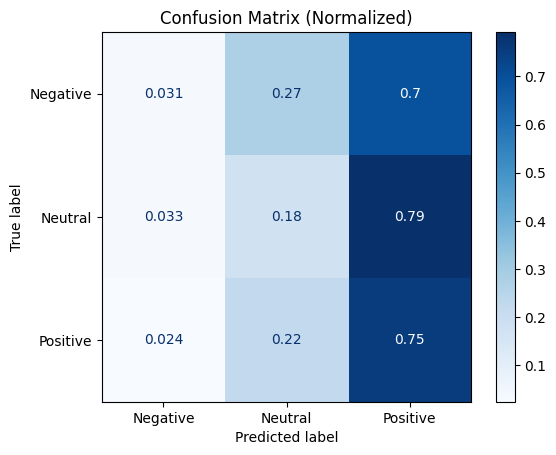

In [30]:
# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=["Negative","Neutral","Positive"])
disp_norm.plot(cmap='Blues')
plt.title("Confusion Matrix (Normalized)")
plt.show()

### 5. Result analysis

The Bayesian network sentiment classifier achieved an accuracy of 39.8%. The model exhibits significantly stronger performance in identifying Positive sentiments (class 1.0), but struggles to accurately classify Neutral (0.0) and especially Negative (-1.0) sentiments.
- Positive (class 1): This class shows the highest performance, with a recall of 75.4% and an F1-score of 0.556. Most Positive sentences are correctly classified, though 22% are misclassified as Neutral and 2.4% as Negative. The model effectively captures the patterns of Positive sentiment.
- Neutral (class 0): The model achieves a recall of 17.5%, suggesting difficulty in correctly recognizing Neutral sentences. A majority are misclassified, particularly as Positive (approximately 79%) and to a lesser extent as Negative (around 3.3%). This indicates that the model lacks the ability to clearly differentiate neutral language, likely due to overlap with sentiment-laden vocabulary or structure.
- Negative (class -1): This is the weakest-performing class with a recall of only 3.1% and an F1-score of 0.055. A striking 70% of Negative sentences are incorrectly predicted as Positive, while 27% are misclassified as Neutral. This suggests that the model frequently mistakes strongly negative expressions for positive ones, likely due to limited or noisy negative training samples or an insufficient modeling of negative sentiment features.

Macro average F1-score is 0.275, indicating poor average performance across all three classes. The weighted average F1-score of 0.330 reflects the disproportionate performance, skewed by the better results on the larger Positive class.

These findings highlight a major class imbalance in model performance. While Positive sentiment is captured well, the model lacks discrimination for Neutral and Negative categories.

### 6. Conclusion

The Bayesian Network approach for sentiment classification explores the probabilistic dependencies among sentiment-related features in text, modeling how different attributes jointly influence the sentiment class. This generative model structure allows for an interpretable and flexible framework, enabling reasoning under uncertainty.

The model achieved an overall accuracy of 39.8% and a weighted F1-score of 0.330, with its strongest performance in detecting Positive sentiment (class 1), which reached a recall of 75.4% and an F1-score of 0.556. However, the model significantly underperformed on Negative (class -1) and Neutral (class 0) sentiments, with particularly low recall and F1-scores for the Negative class.

Using the Bayesian Network can have several advantages:
- The directed acyclic graph structure makes the dependencies among variables transparent and easy to analyze.
- Bayesian inference allows the model to make predictions even with missing or uncertain information.
- Bayesian Networks can be computationally efficient when the structure is well-constrained and features are carefully selected.

Besides, there are also drawbacks in using this kind of model:
- The model assumes conditional independence among variables given their parents, which may oversimplify complex sentiment patterns.
- Performance depends heavily on the quality and informativeness of selected features.
- The model struggles with nuanced or ambiguous expressions common in Neutral and Negative sentiments, as reflected in the confusion matrix and classification report.

In summary, while the Bayesian Network shows promise for interpretable and probabilistic sentiment classification, its limited performance in less distinct sentiment classes suggests the need for richer feature sets or hybrid approaches to better capture subtleties in natural language.